In [1]:
from peri import util
from peri.viz.interaction import OrthoViewer
import matplotlib



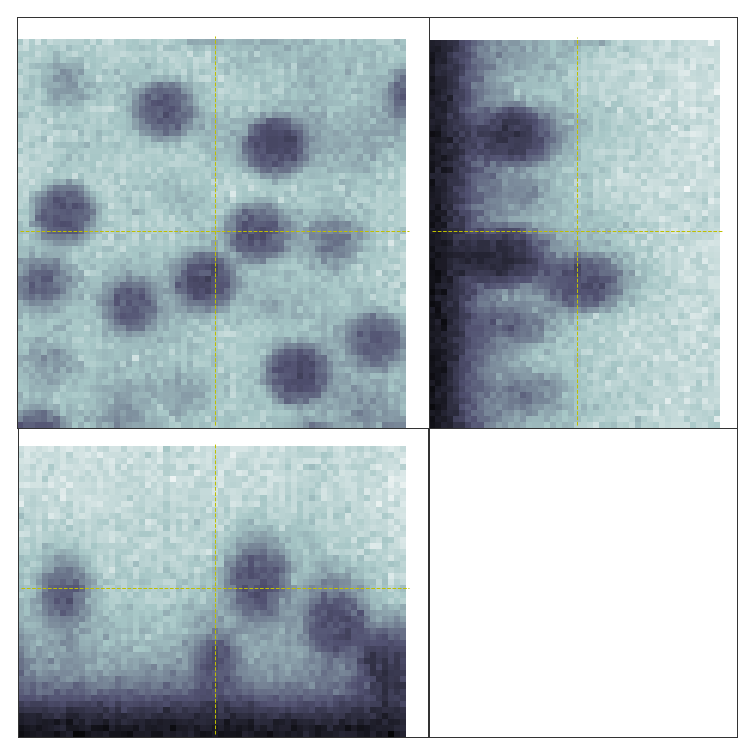

In [2]:
im = util.RawImage('../../Downloads/small_confocal_image.tif')
OrthoViewer(im.get_image())

The image is comprised of a bunch of particles and a cover slip, so we put these components into the model.

The position of the spheres is loaded in, originally found using trackpy algorithm to make an initial guess of the positions of the particles. By looking at the image, they have decided that the cover slip is at a point z=6 from the bottom of the image. Making these intial guesses helps to speed up peri's fit of the model.

In [3]:
import numpy
from peri.comp import objs
coverslip = objs.Slab(zpos=6)
particle_positions = numpy.load('../../Downloads/particle-positions.npy')
particle_radii = 5.0
particles = objs.PlatonicSpheresCollection(particle_positions, particle_radii)

Check our intial guesses using OrthoPrefeature to overlay the extracted particle positions onto the image.

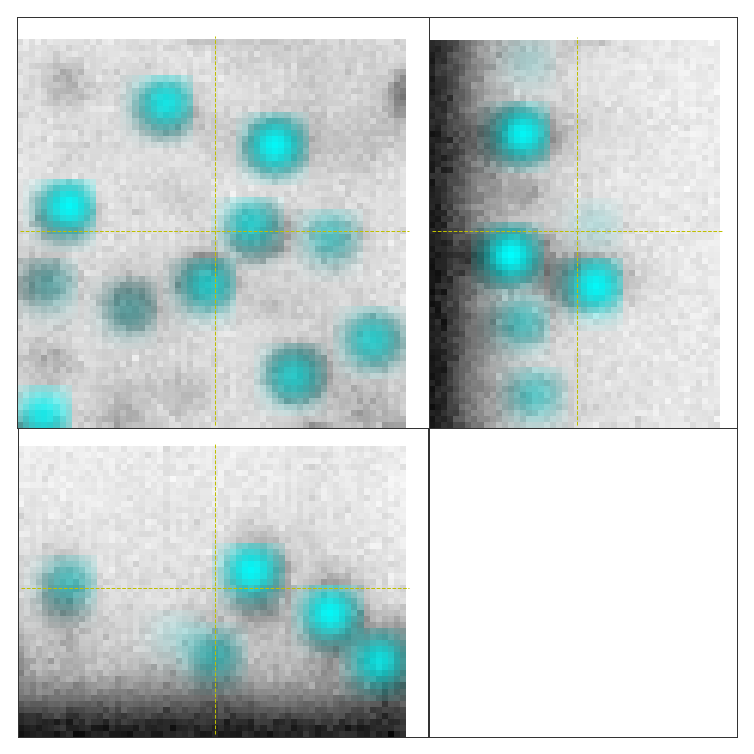

In [4]:
from peri.viz.interaction import OrthoPrefeature
OrthoPrefeature(im.get_image(), particle_positions, viewrad=3.0)

If we're doing this interactively so we can click on the image etc, we can use A and R to switch into a mode where we can add or remove particles. We can then click on the points we want to do the adding/removal.

Group the two objects (particles and coverslip) together because they both have the same effect on the image - they exclude dye from regions of the image. It therefore makes sense to treat them as one object when we make the mathematical model. We specify that it is a group of objects rather than any other type of components.

In [5]:
from peri.comp import comp
objects = comp.ComponentCollection([particles, coverslip], category='obj')

The image is illuminated by a laser with stripe-like imperfections, so we add that in next. Choice of how do describe this illumination required a lot of experimentation. You will need to figure out how many parameters to include depending on the microscope and image size - come to this later.

In [6]:
from peri.comp import ilms
illumination = ilms.BarnesStreakLegPoly2P1D(npts=(16,10,8,4), zorder=8)

We also add a background intensity always registered by the detector. In this case it varies with position. This information came from knowledge of the microscope. We define it like an illumination, but change the category from the default to background so peri knows it's different. The order of the legendre polynomial was found empirically.

In [7]:
background = ilms.LegendrePoly2P1D(order=(7,2,2), category='bkg')

For numerical reasons, we also include an offset which takes into account high-frequency changes in the background.

In [8]:
from peri.comp import comp
offset = comp.GlobalScalar(name='offset', value=0.)

We can see the image is blurry so we add that in. If you don't want or need an exact optical description of your point-spread function, there are things like gaussians stored in the module peri.comp.psfs

In [9]:
from peri.comp import exactpsf
point_spread_function = exactpsf.FixedSSChebLinePSF()

Now we have our components, we need to describe how they interact. We use the model for a confocal image. The model knows things like the fact that objects in the sample exclude dye from certain regions, the dye is illuminated by a laser, etc.

In [10]:
from peri import models
model = models.ConfocalImageModel()

We can look at the mathematical form of the model by printing it.

In [11]:
print model 

ConfocalImageModel : H(I*(1-P)+C*P) + B


Finally we combine the model and its components to create a model image. We create a State or ImageState which is an object containing the image, the model, its parameters and values, and the model image.

In [12]:
from peri import states
st = states.ImageState(im, [objects, illumination, background, point_spread_function, offset], mdl=model)

## ^N.B. I had to change the source code in objs.py, line 884 from mp = -(m1 | m0) to mp = ~(m1 | m0) as the use of - on booleans has been deprecated

We can link together parameters that physically have to scale together, e.g. the ratio of z-pixel to xy-pixel size is the same whether we're looking at a point spread function or the particles. Here we link those these parameters together. Except it doesn't currently work, I can't see why. Oh, I restarted the kernel and now it does work.

In [13]:
from peri import runner
runner.link_zscale(st)

We can look at the error of our current model, this gives us the sum of the squares of the residuals. We can also use st.residuals, which gives the residuals themselves (i.e. the difference between the model image and the experimental image.

In [14]:
print st.error

8087.551041476323


We can fit the state and improve the error significantly. 
## This is the bit that takes a lot of time, and we don't want to have to repeat it over and over again.
If the fit isn't good enough, we can either re-run or we can run: runner.finish_state(st)

In [15]:
from peri import runner
runner.optimize_from_initial(st)

2019-08-06 12:05:17,398 - INFO - peri.runner - Initial burn:
2019-08-06 12:05:17,411 - INFO - peri.opt - Start of loop 0:	8087.551041
/Users/s1101153/anaconda3/envs/py2/lib/python2.7/site-packages/peri/states.py:38: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = field[slicer].ravel()
2019-08-06 12:05:43,474 - INFO - peri.opt - Globals,   loop 0:	162.814561333
2019-08-06 12:05:56,666 - INFO - peri.opt - Particles, loop 0:	107.303047912
2019-08-06 12:06:23,495 - INFO - peri.opt - Globals,   loop 1:	97.7925023742
2019-08-06 12:06:49,066 - INFO - peri.opt - Particles, loop 1:	95.1466363533
2019-08-06 12:07:36,689 - INFO - peri.opt - Globals,   loop 2:	93.9466126842
2019-08-06 12:07:52,749 - INFO - peri.opt - Particles, loop 2:	93.7489771566
2019-08-06 12:07:52,

ImageState [
    stats: E=67.0970738485 LL=-445937144.336
    model: ConfocalImageModel : H(I*(1-P)+C*P) + B
    image: RawImage <../../Downloads/small_confocal_image.tif: Tile [0, 0, 0] -> [48, 64, 64] ([48, 64, 64])>
    ----------------------------------------------------------------------
    obj: ComponentCollection [
        obj: PlatonicSpheresCollection N=46, zscale=0.868293405577
        obj: Slab <{'slab-theta': -0.0037035001421705685, 'slab-zpos': 4.902979900240732, 'slab-phi': -0.0011031709892089182}>
    ]
    ilm: BarnesStreakLegPoly2P1D [(16, 10, 8, 4) 8]
    bkg: LegendrePoly2P1D [(7, 2, 2)]
    psf: FixedSSChebLinePSF [35 17 25]
    offset: GlobalScalar [{'offset': 2.2637057961934235}]
]

## ^Here there is another boolean negative issue, this time in line 2126 of optimize.py: rscale_mask = -globals_mask

In [17]:
print st.error

67.09707384851042


In [18]:
runner.finish_state(st)

------------------------------ADDING------------------------------
  Z	  Y	  X	  R	|	 ERR0		 ERR1
------------------------------ADDING------------------------------
  Z	  Y	  X	  R	|	 ERR0		 ERR1
------------------------------ADDING------------------------------
  Z	  Y	  X	  R	|	 ERR0		 ERR1
------------------------------ADDING------------------------------
  Z	  Y	  X	  R	|	 ERR0		 ERR1
26.58	67.64	29.28	5.37	|	67.097  	66.880
------------------------------ADDING------------------------------
  Z	  Y	  X	  R	|	 ERR0		 ERR1
------------------------------ADDING------------------------------
  Z	  Y	  X	  R	|	 ERR0		 ERR1
------------------------------ADDING------------------------------
  Z	  Y	  X	  R	|	 ERR0		 ERR1
------------------------------ADDING------------------------------
  Z	  Y	  X	  R	|	 ERR0		 ERR1
------------------------------ADDING------------------------------
  Z	  Y	  X	  R	|	 ERR0		 ERR1
2019-08-06 14:00:15,366 - INFO - peri.opt - Start  ``finish``:	66.7678781017


In [19]:
print(st.error)

66.35538358104205


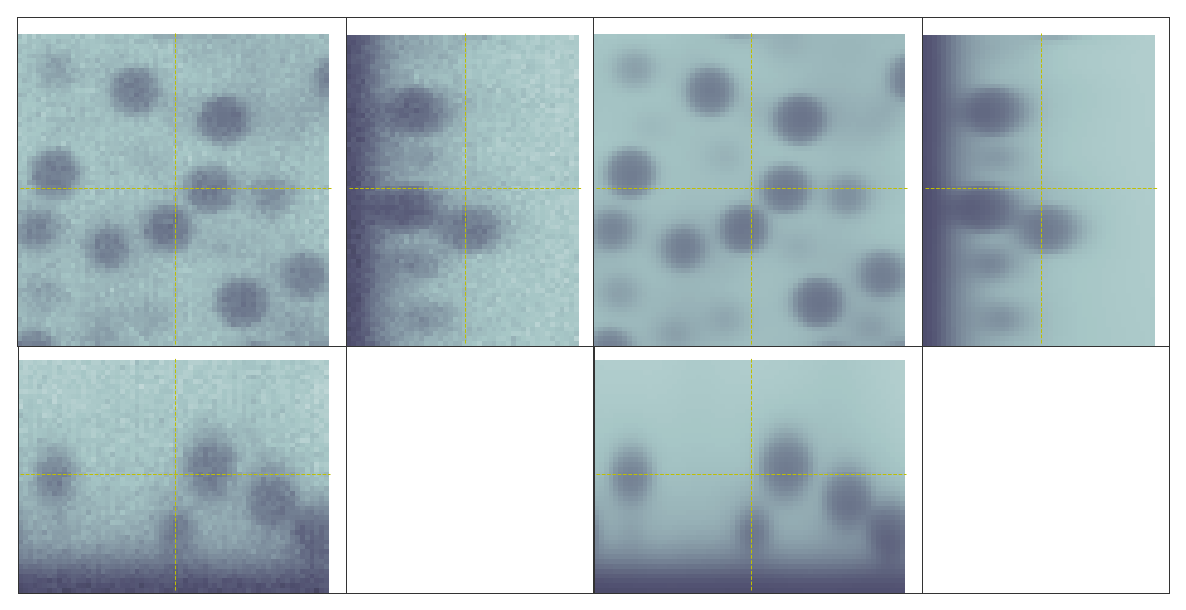

In [20]:
from peri.viz.interaction import OrthoManipulator
OrthoManipulator(st)

In [26]:
from peri import states
states.save(state=st,filename='optimised-peri-save.pkl')

In [27]:
#code to run in terminal python if we want it to be interactive
# import matplotlib
# matplotlib.rcParams["backend"]="TkAgg"
# from peri import states
# st2=states.load('optimised-peri-save.pkl')
# from peri.viz.interaction import OrthoManipulator
# OrthoManipulator(st2)

As I currently can't visualise this interactively (even running it in the shell causes errors once I try to use Q to cycle through the different views - TclError: this isn't a Tk application. Running without Tkagg using pythonw is so slow I can't tell if it's working or not, definitely not practical), I will move on to look at the rest of the walkthrough. At least when I'm doing the machine learning, I should generally be avoiding these interactive plots anyway so hopefully it's not too important for my work.

In [28]:
from peri.viz import plots
plots.examine_unexplained_noise(st)

ImportError: cannot import name AnchoredText